# Project Overview

Within the field of film criticism and public feedback, the extensive collection of IMDb movie reviews represents a wealth of information that is ready for examination. The goal of my research was to create an automated system that could analyse these evaluations in real-time and uncover insights regarding audience sentiment on a large scale. The main goal was to classify the opinions stated in each review as either favourable or negative in order to provide a more complex picture of the responses from the public. This project made sure that this attempt was thoroughly documented for ease of comprehension and replication.

![Screenshot](Screenshot.png)

In [1]:
'''
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade
!pip install spacy --upgrade
!pip install textblob --upgrade
!pip install tensorflow --upgrade
'''

'\n!pip install gensim --upgrade\n!pip install keras --upgrade\n!pip install pandas --upgrade\n!pip install spacy --upgrade\n!pip install textblob --upgrade\n!pip install tensorflow --upgrade\n'

# Importing librarys using for this work

In [2]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk import download

# selenium
from selenium import webdriver
from selenium.webdriver.chrome.service import Service

# Wordcloud
from wordcloud import WordCloud,STOPWORDS

# Word2vec
import gensim

# Utility
import re
import requests
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools
import string
import seaborn as sns
from bs4 import BeautifulSoup
from textblob import TextBlob
from textblob import Word
import warnings
warnings.filterwarnings('ignore')

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


/Users/subinhyun/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Step1. Web Crawling from IMDb

### 1. Code for extracting all of reviews from the IMDb homepage 

In [3]:
'''
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
from bs4 import BeautifulSoup
import pandas as pd

reviews_data = []

s = Service('/opt/homebrew/bin/chromedriver')
driver = webdriver.Chrome(service=s)
url = 'https://www.imdb.com/title/tt5971474/reviews?ref_=tt_ql_3'
driver.get(url)

# Wait for the initial reviews to load
time.sleep(5)

try:
    # Loop to click the "Load More" button
    while True:
        # Wait for the "Load More" button to be clickable
        load_more_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CLASS_NAME, "ipl-load-more__button"))
        )
        # Scroll to the button (necessary if the button is out of the viewport)
        driver.execute_script("arguments[0].scrollIntoView(true);", load_more_button)
        time.sleep(2) # A short delay to ensure the page has scrolled
        load_more_button.click()
        
        # Wait for the new reviews to load
        time.sleep(5)
        
        # Optional: Stop condition if you want to limit the number of clicks
        # if len(driver.find_elements_by_class_name('lister-item-content')) >= desired_number_of_reviews:
        #     break
        
except Exception as e:
    print("Finished loading all reviews or encountered an error:", str(e))

# Now that all reviews are loaded, proceed with BeautifulSoup
soup = BeautifulSoup(driver.page_source, 'html.parser')
review_containers = soup.find_all('div', class_='lister-item-content')

for review in review_containers:
    review_title = review.find('a', class_='title').text.strip()
    review_text = review.find('div', class_='text').text.strip()
    user_link = review.find('span', class_='display-name-link').find('a', href=True)['href']
    user_id = user_link.split('/')[2]
    rating_span = review.find('span', class_='rating-other-user-rating')
    rating = rating_span.find('span').text if rating_span else 'No rating'
    
    reviews_data.append({
        'user_id': user_id,
        'review_title': review_title,
        'rating': rating,
        'review_text': review_text
    })

reviews_df = pd.DataFrame(reviews_data)
print(reviews_df)
driver.quit()
'''

'\nfrom selenium import webdriver\nfrom selenium.webdriver.chrome.service import Service\nfrom selenium.webdriver.common.by import By\nfrom selenium.webdriver.support.ui import WebDriverWait\nfrom selenium.webdriver.support import expected_conditions as EC\nimport time\nfrom bs4 import BeautifulSoup\nimport pandas as pd\n\nreviews_data = []\n\ns = Service(\'/opt/homebrew/bin/chromedriver\')\ndriver = webdriver.Chrome(service=s)\nurl = \'https://www.imdb.com/title/tt5971474/reviews?ref_=tt_ql_3\'\ndriver.get(url)\n\n# Wait for the initial reviews to load\ntime.sleep(5)\n\ntry:\n    # Loop to click the "Load More" button\n    while True:\n        # Wait for the "Load More" button to be clickable\n        load_more_button = WebDriverWait(driver, 10).until(\n            EC.element_to_be_clickable((By.CLASS_NAME, "ipl-load-more__button"))\n        )\n        # Scroll to the button (necessary if the button is out of the viewport)\n        driver.execute_script("arguments[0].scrollIntoView(tr

>Given the voluminous quantity of reviews, totaling 1,398 on the IMDb homepage, the endeavor to crawl all reviews is significantly time-consuming. Therefore, this project has opted to limit the scope of data extraction to a single page for the purposes of submission.

### 2. Code for reading several reviews from the IMDb single homepage

In [4]:
# Initialize an empty list to store review data
reviews_data = []

# Specifying the path for ChromeDriver, required from Selenium 4.x onwards
s = Service('/opt/homebrew/bin/chromedriver')
driver = webdriver.Chrome(service=s)
url = 'https://www.imdb.com/title/tt5971474/reviews?ref_=tt_ql_3'
driver.get(url)

# Waiting for the page to load to ensure all elements are accessible
time.sleep(5)

# Creating a BeautifulSoup object to parse the HTML content
soup = BeautifulSoup(driver.page_source, 'html.parser')

# Locating all review container elements on the page
review_containers = soup.find_all('div', class_='lister-item-content')

# Iterating through each review container to extract and store relevant details
for review in review_containers:
    review_title = review.find('a', class_='title').text.strip()
    review_text = review.find('div', class_='text').text.strip()
    user_link = review.find('span', class_='display-name-link').find('a', href=True)['href']
    user_id = user_link.split('/')[2]
    rating_span = review.find('span', class_='rating-other-user-rating')
    rating = rating_span.find('span').text if rating_span else 'No rating'
    
    # Appending extracted data to the reviews_data list as dictionaries
    reviews_data.append({
        'user_id': user_id,
        'review_title': review_title,
        'rating': rating,
        'review_text': review_text
    })

# Converting the list of dictionaries into a pandas DataFrame for better data manipulation and visualization
reviews_df = pd.DataFrame(reviews_data)

# Displaying the DataFrame to verify the extracted data
print(reviews_df)

# Closing the WebDriver session to free resources
driver.quit()


        user_id                                       review_title     rating  \
0   ur125201937  WHY WHY WHY DISNEY? DO YOU KEEP MAKING LIVE AC...          6   
1   ur106964964                A Shallow Dive That Missed its Mark          6   
2   ur133716455                                  It's hard to rate          6   
3    ur88182480  Another live-action remake that doesn't quite ...          6   
4    ur27470816                           An insult to the orignal          3   
5    ur30238244                                  I'm just not sure          6   
6    ur16432189                          Unapologetically mediocre          1   
7    ur28036675                                    Dark and Gloomy  No rating   
8   ur131783850  This is one of the best Disney live action rem...          8   
9   ur122459646                                 Original is Better          6   
10  ur147326874  Another pointless remake that's worse than the...          1   
11   ur22852340             

# Step2. Sentimental Analysis

## 1) Using SentimentIntensityAnalyzer

In [5]:
# Download the NLTK Vader lexicon (if not already downloaded)
download('vader_lexicon')

# Create a SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment polarity
def get_sentiment_polarity(text):
    scores = sia.polarity_scores(text)
    compound_score = scores['compound']

    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment analysis to reviews_df
reviews_df['sentiment'] = reviews_df['review_text'].apply(get_sentiment_polarity)

# Display the DataFrame with sentiment analysis results
reviews_df


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/subinhyun/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,user_id,review_title,rating,review_text,sentiment
0,ur125201937,WHY WHY WHY DISNEY? DO YOU KEEP MAKING LIVE AC...,6,You'd think a company like Disney with the amo...,Positive
1,ur106964964,A Shallow Dive That Missed its Mark,6,This live action remake was a disappointing at...,Negative
2,ur133716455,It's hard to rate,6,I went to see this movie with the attitude tha...,Negative
3,ur88182480,Another live-action remake that doesn't quite ...,6,Let me start off by saying I was impatiently a...,Positive
4,ur27470816,An insult to the orignal,3,This movie just wasn't good... They added some...,Negative
5,ur30238244,I'm just not sure,6,I wouldn't say I hated it but I just feel like...,Positive
6,ur16432189,Unapologetically mediocre,1,"The Little Mermaid is like a Disney parade, a ...",Positive
7,ur28036675,Dark and Gloomy,No rating,No excitement or joy. Maybe the movie was rush...,Positive
8,ur131783850,This is one of the best Disney live action rem...,8,The Little Mermaid (2023) is a movie that my d...,Positive
9,ur122459646,Original is Better,6,The Little Mermaid (2023) is a live-action ada...,Positive


>However, the implemented code resulted in the misclassification of reviews with a rating of 1 as positive sentiment. This outcome suggests limitations in the model's accuracy and raises concerns regarding its reliability for sentiment analysis tasks. Consequently, I opted to explore alternative approaches, specifically employing machine learning techniques for data sentiment analysis.

## 2) Machine learning for data sentimental analysis

## a) Dataset Description
- kaggle data: IMDB dataset having 50K movie reviews for binary (25K positive and 25K negative) sentiment classification

In [6]:
#importing the training data
df = pd.read_csv('IMDB Dataset.csv')

print(df.shape)
df.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [7]:
#sentiment count
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

# b) Data Preprocessing for crawling reviews
1. Tokenize each review
2. Remove HTML tags
3. Remove punctuation 
4. Remove stopwords
5. Convert slang words to their standard form

In [8]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/subinhyun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/subinhyun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
# Removing HTML tags from reviews
# Necessary to clean the text data for better analysis by removing unnecessary HTML syntax.

def remove_br_tags(text):
    cleaned_text = text.replace('<br />', '')
    return cleaned_text

df['review']= df['review'].apply(remove_br_tags)

In [11]:
# Removing punctuation from the text
# Punctuation can distort text analysis by treating words with punctuation as different from the same words without punctuation.

def nopunct(mess):
    nopunc = [x for x in mess if x not in string.punctuation]
    nopunc = ''.join(nopunc)
    return nopunc

In [12]:
df['review']= df['review'].apply(nopunct)

In [13]:
df['review'][1]

'A wonderful little production The filming technique is very unassuming very oldtimeBBC fashion and gives a comforting and sometimes discomforting sense of realism to the entire piece The actors are extremely well chosen Michael Sheen not only has got all the polari but he has all the voices down pat too You can truly see the seamless editing guided by the references to Williams diary entries not only is it well worth the watching but it is a terrificly written and performed piece A masterful production about one of the great masters of comedy and his life The realism really comes home with the little things the fantasy of the guard which rather than use the traditional dream techniques remains solid then disappears It plays on our knowledge and our senses particularly with the scenes concerning Orton and Halliwell and the sets particularly of their flat with Halliwells murals decorating every surface are terribly well done'

In [14]:
# Removing stopwords from the text
# Stopwords are common words that usually don't carry much meaning and can be removed to focus on significant words.

def remove_stopword(mess):
    stpwrd = [char for char in mess if char not in stopwords.words('english')]
    stpwrd = ''.join(stpwrd)
    return stpwrd

In [15]:
# Converting slang words to their standard form
# Slang conversion can help in standardizing the text and improving the analysis by using common vocabulary.

def convert_slang(text):
    words = word_tokenize(text)
    converted_words = []

    for word in words:
        # Get synonyms for the current word
        synonyms = wordnet.synsets(word)
        
        # Use the first synonym as replacement (if available)
        replacement = synonyms[0].lemmas()[0].name() if synonyms else word
        converted_words.append(replacement)

    converted_text = " ".join(converted_words)
    return converted_text

## c) Creating a Bag of Words model
> BoW model is a way of representing text data in terms of a matrix where each row represents a document and each column represents a unique word in the vocabulary.


In [16]:
bow_transformer = CountVectorizer(analyzer='word').fit(df['review'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

221457


In [17]:
reviews_bow = bow_transformer.transform(df['review'])

In [18]:
mess1 = df['review'][1]
bow1= bow_transformer.transform([mess1])
#print(bow1.get_feature_names()[189202])

In [19]:
sparsity = (100.0 * reviews_bow.nnz / (reviews_bow.shape[0] * reviews_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


## d) Creating a TF-IDF model
> TF-IDF, short for term frequency-inverse document frequency, is a numerical statistic intended to reflect how important a word is to a document in a collection or corpus.

In [31]:
tfidf_transformer = TfidfTransformer().fit(reviews_bow)

tfidf4 = tfidf_transformer.transform(bow1)
print(tfidf4)

  (0, 220037)	0.02781550055804487
  (0, 218479)	0.06631252337972005
  (0, 217965)	0.05807461038924152
  (0, 216906)	0.06529483906350941
  (0, 216316)	0.06846626532278506
  (0, 215635)	0.09642823564950487
  (0, 214634)	0.03714103864551537
  (0, 213374)	0.11567079556146997
  (0, 212164)	0.04850645012896031
  (0, 210372)	0.09800391717514034
  (0, 208867)	0.06929376818334561
  (0, 207314)	0.06299016304854943
  (0, 204243)	0.1443009602116856
  (0, 202174)	0.06364379360371003
  (0, 200416)	0.09744797422178998
  (0, 199216)	0.04218468818714778
  (0, 198496)	0.03550030151911385
  (0, 195731)	0.05238920451518449
  (0, 195036)	0.042187761650914826
  (0, 194619)	0.03816464923834743
  (0, 194451)	0.2696555281819015
  (0, 194134)	0.038073106213606586
  (0, 193777)	0.16744948172995822
  (0, 193754)	0.09383161219744732
  (0, 192777)	0.10477442569280347
  :	:
  (0, 68234)	0.07123400674531742
  (0, 66155)	0.05076376357854799
  (0, 64366)	0.12080813518407862
  (0, 64287)	0.06644338712630578
  (0, 60810)

In [21]:
#To transform the entire bag-of-words corpus into TF-IDF corpus at once
reviews_tfidf = tfidf_transformer.transform(reviews_bow)
print(reviews_tfidf.shape)

(50000, 221457)


## e) Training a Multinomial Naive Bayes model

In [22]:
# Chosen for its suitability for classification with discrete features (e.g., word counts for text classification).
model = MultinomialNB().fit(reviews_tfidf, df['sentiment'])

In [23]:
# Splitting the dataset into training and testing sets

msg_train, msg_test, label_train, label_test = \
train_test_split(df['review'],df['sentiment'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

40000 10000 50000


In [24]:
# Initialize the TF-IDF transformer
vectorizer = TfidfVectorizer()

# Train the transformer based on the training data
X_train_tfidf = vectorizer.fit_transform(msg_train)

# Initialize and train the model
model = LogisticRegression()
model.fit(X_train_tfidf, label_train)

# Preprocess the new review data
new_review_tfidf = vectorizer.transform(reviews_df['review_text']) # Use the same TF-IDF transformer

# Predict the sentiment for each review
predicted_sentiments = model.predict(new_review_tfidf)

# Add the predicted sentiment as a new column in reviews_df
reviews_df['predicted_sentiment'] = predicted_sentiments

# The 'predicted_sentiment' column will contain values 'positive' or 'negative'
print(reviews_df[['review_text', 'predicted_sentiment']])

                                          review_text predicted_sentiment
0   You'd think a company like Disney with the amo...            negative
1   This live action remake was a disappointing at...            negative
2   I went to see this movie with the attitude tha...            negative
3   Let me start off by saying I was impatiently a...            negative
4   This movie just wasn't good... They added some...            negative
5   I wouldn't say I hated it but I just feel like...            negative
6   The Little Mermaid is like a Disney parade, a ...            negative
7   No excitement or joy. Maybe the movie was rush...            negative
8   The Little Mermaid (2023) is a movie that my d...            positive
9   The Little Mermaid (2023) is a live-action ada...            positive
10  The latest in Disney's attempt to cash in on a...            negative
11  I'm definitely the original film's generation ...            positive
12  I was hoping that they wouldn't. B

In [25]:
reviews_df['predicted_sentiment'].value_counts()

predicted_sentiment
negative    18
positive     7
Name: count, dtype: int64

# Step3. Visualisation of results with pie chart

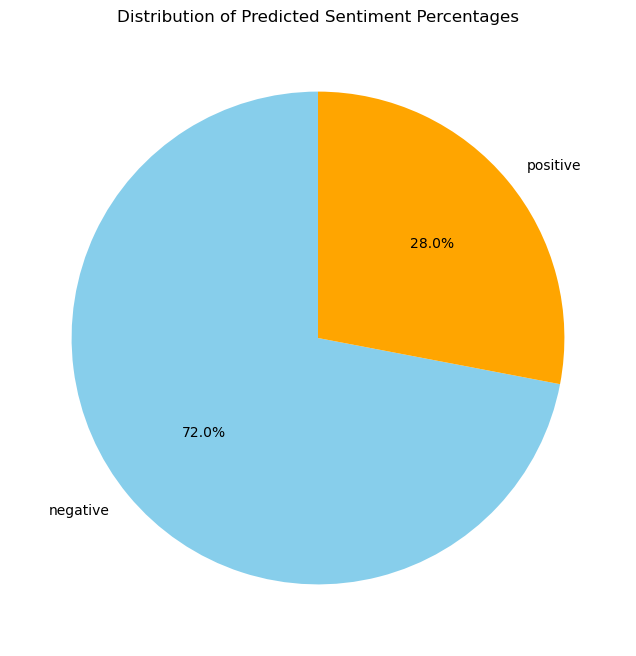

In [26]:
# Assuming reviews_df['predicted_sentiment'] is already defined
# Calculate the percentage of each sentiment category
sentiment_counts = reviews_df['predicted_sentiment'].value_counts()
sentiment_percentage = sentiment_counts / sentiment_counts.sum() * 100

# Plotting the pie chart
plt.figure(figsize=(8, 8))  # Optional: Adjust the figure size as needed
sentiment_percentage.plot.pie(autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange', 'green'])
plt.title('Distribution of Predicted Sentiment Percentages')
plt.ylabel('')  # Remove the y-label as it's not necessary for pie charts
plt.show()

## Wordcloud

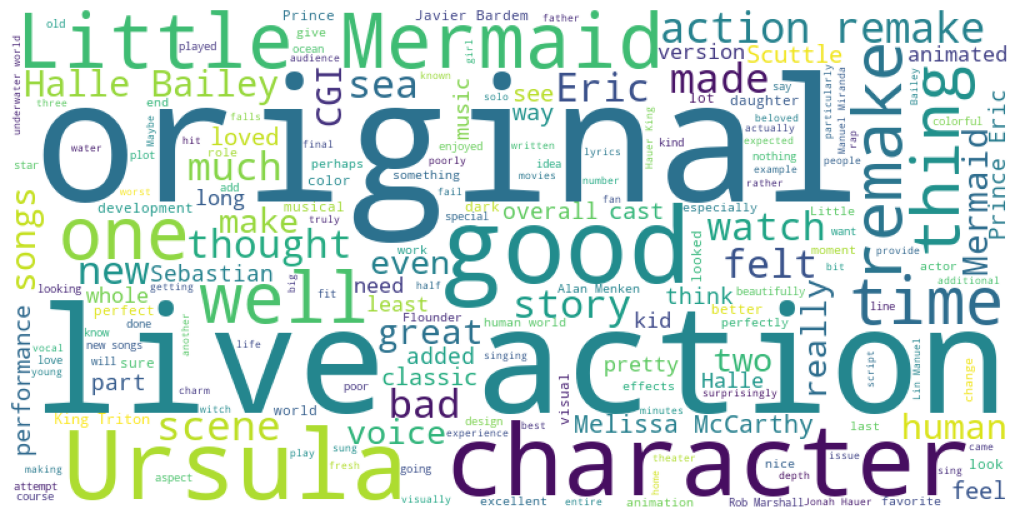

In [29]:
# Assuming 'reviews_df['review_text']' contains your text data
movie_names = reviews_df['review_text'].tolist()  # Convert the column to a list
text = ' '.join(movie_names)  # Join all movie names into a single string

# Define custom stopwords
custom_stopwords = STOPWORDS.union({'film', 'movie','Disney','Ariel','song'})

# Create a WordCloud object using the custom stopwords
wordcloud = WordCloud(width=800, height=400, background_color='white', 
                      stopwords=custom_stopwords, min_font_size=8).generate(text)

# Plot the WordCloud image                        
plt.figure(figsize=(10, 6), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()


# Step4. Evaluation

In [27]:
# Prediction for "The Little Mermaid" reviews
prediction = model.predict(new_review_tfidf)

# Evaluate the performance on the test dataset
test_tfidf = vectorizer.transform(msg_test)
print("Test Accuracy: ", model.score(test_tfidf, label_test))


Test Accuracy:  0.8902


In [28]:
# Assuming you have already calculated predictions for the test set as
test_predictions = model.predict(test_tfidf)

# Calculate Precision
precision = precision_score(label_test, test_predictions, pos_label='positive', average='binary')
print("Precision: ", precision)

# Calculate Recall
recall = recall_score(label_test, test_predictions, pos_label='positive', average='binary')
print("Recall: ", recall)

# Calculate F1 Score
f1 = f1_score(label_test, test_predictions, pos_label='positive', average='binary')
print("F1 Score: ", f1)


Precision:  0.8808402041617589
Recall:  0.9013660104459622
F1 Score:  0.8909849086576648
